# Use pre-trained Model with various test sets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from SmilesTools import smiUtil as SU
from AE4SmilesLib import CNAE, tbHistoryPlot

Using TensorFlow backend.


In [2]:
sm = SU()

Keep parameters in dictionary  
**lrep** : hidden rep size  
**nEL** : number of conv + maxpool block  
**reg** : activity L1 regulation factor  
**flt** : number of conv filters per layer  
**opt** : optimizer to use  
**ngpu** : number of gpus to use   
**batch** : minibatch size  
**EPO** : number of epochs  

In [3]:
bp = {
    'lrep' : 145,
    'nEL' : 1,
    'reg' : 1.0e-9,
    'flt' : 32,
    'kern' : 5,
    'opt' : 'adam',
    'ngpu' : 1,
    'batch' : 256,
    'EPO' : 30
    }

bcn = CNAE(sm,**bp)

Network weights need to be created from net of same structure; **_lrep, nEL, flt & kern_** need to be same.

In [4]:
bcn.loadw('data/test5MCNNv3Co1.hdf5')

In [5]:
dat = pd.read_pickle('data/6MSmiles.pkl')

In [6]:
k = 2000
zinctst = dat[-k:]
zinctst = zinctst.reset_index(drop=True)
del dat
zinctst.head()

,Molecule
0,O=C(Cn1nc(ccc1=O)-c1cccc2ccccc12)NC1CCCCCC1
1,COc1cc(cc(OC)c1OC)C(=O)NCCn1c(C)nc2ncccc2c1=O
2,Fc1cc(F)c(CC(=O)NCCCc2nnc3ccccn23)cc1F
3,Cc1nc2ccc(F)cc2c(=O)n1CC(=O)Nc1nc(cs1)-c1cccnc1
4,Clc1cccc(c1)N1CCN(CC1)C(=O)CCC(=O)NCc1cccnc1


In [7]:
zoh = sm.smi2OH(zinctst)

In [8]:
dat = pd.read_csv('data/ChEMBL23_5k.csv',sep='\t')
dat = dat[0:k]
ch23oh = sm.smi2OH(dat)

dat = pd.read_csv('data/UNPD_5k.csv',sep='\t')
dat = dat[0:k]
unpdoh = sm.smi2OH(dat)

dat = pd.read_csv('data/DM_5k.csv',sep='\t')
dat = dat[0:k]
dmoh = sm.smi2OH(dat)

In [9]:
for dta in [zoh, ch23oh, dmoh, unpdoh]:
    xp = bcn.aen.predict(dta)
    _   = sm.getScore(dta,xp)

Perfect: 79.85 Good: 82.25 Match: 99.08
Perfect: 42.10 Good: 52.85 Match: 94.21
Perfect: 32.00 Good: 45.55 Match: 90.98
Perfect: 6.80 Good: 13.05 Match: 83.74


### Continue training with UNPD training data.

In [10]:
dat = pd.read_csv('data/UNPD_139k.csv',sep='\t')
dat.drop('Name',axis=1,inplace=True)

In [11]:
utrainoh = sm.smi2OH(dat)

In [12]:
bcn.aeTrain(utrainoh,'utrain',vb=1,esp=20)

Train on 111200 samples, validate on 27800 samples
Epoch 1/30
111200/111200 [==============================] - 17s 154us/step - loss: 0.0102 - acc: 0.9968 - jaccard: 0.8690 - dice_loss: 0.0493 - val_loss: 0.0114 - val_acc: 0.9970 - val_jaccard: 0.8752 - val_dice_loss: 0.0474
Epoch 2/30
111200/111200 [==============================] - 14s 129us/step - loss: 0.0075 - acc: 0.9975 - jaccard: 0.8865 - dice_loss: 0.0386 - val_loss: 0.0121 - val_acc: 0.9971 - val_jaccard: 0.8795 - val_dice_loss: 0.0458
Epoch 3/30
111200/111200 [==============================] - 14s 126us/step - loss: 0.0069 - acc: 0.9977 - jaccard: 0.8944 - dice_loss: 0.0353 - val_loss: 0.0124 - val_acc: 0.9971 - val_jaccard: 0.8821 - val_dice_loss: 0.0450
Epoch 4/30
111200/111200 [==============================] - 14s 125us/step - loss: 0.0062 - acc: 0.9979 - jaccard: 0.9020 - dice_loss: 0.0320 - val_loss: 0.0121 - val_acc: 0.9973 - val_jaccard: 0.8857 - val_dice_loss: 0.0433
Epoch 5/30
111200/111200 [=======================

('data/utrain.hdf5', 'logs/utrain')

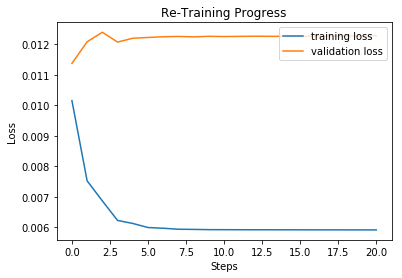

In [13]:
tbHistoryPlot('logs/utrain')

In [14]:
for dta in [zoh, ch23oh, dmoh, unpdoh]:
    xp = bcn.aen.predict(dta)
    _   = sm.getScore(dta,xp)

Perfect: 12.65 Good: 26.30 Match: 94.02
Perfect: 13.75 Good: 26.30 Match: 91.54
Perfect: 15.08 Good: 29.56 Match: 88.60
Perfect: 22.75 Good: 29.90 Match: 91.46


### Merge 139k subset of original training set (5M ZincDB) with new data from UNPD. 
- assume that this will reduce degredation of Zinc test set performance and enhance that of the UNPD test set.

In [15]:
bcn.loadw('data/test5MCNNv3Co1.hdf5') #reset weights

In [16]:
dat = pd.read_csv('data/UNPD_139k.csv',sep='\t')
dat.drop('Name',axis=1,inplace=True)
datz = pd.read_pickle('data/6MSmiles.pkl')
datz = datz[0:139000]
dat = pd.concat([dat,datz],ignore_index=True)
dat = dat.sample(frac=1).reset_index(drop=True) #shuffle rows
dat.head()

,Molecule
0,COc1cc2C3C4N(CCC4=CC(O)C3OC(C)=O)Cc2cc1O
1,CC=C(C)C(=O)OC1C2C3C4N(C)CC5(C)C(O)C(O)CC44C(C...
2,COc1cc(O)c(C)c2CCc3c(OC)c(O)ccc3-c12
3,Cn1ccnc1SCC(=O)Nc1ccc2OCOc2c1
4,CC(=O)OC(C)(C)C=CCC(C)=CC(O)CC(C)(O)C=C


In [17]:
utrainoh = sm.smi2OH(dat)

In [18]:
bcn.aeTrain(utrainoh,'utrain2',vb=1,esp=20)

Train on 222400 samples, validate on 55600 samples
Epoch 1/30
222400/222400 [==============================] - 30s 133us/step - loss: 0.0093 - acc: 0.9977 - jaccard: 0.9219 - dice_loss: 0.0357 - val_loss: 0.0088 - val_acc: 0.9978 - val_jaccard: 0.9236 - val_dice_loss: 0.0344
Epoch 2/30
222400/222400 [==============================] - 29s 128us/step - loss: 0.0087 - acc: 0.9978 - jaccard: 0.9232 - dice_loss: 0.0344 - val_loss: 0.0084 - val_acc: 0.9979 - val_jaccard: 0.9245 - val_dice_loss: 0.0335
Epoch 3/30
222400/222400 [==============================] - 28s 124us/step - loss: 0.0084 - acc: 0.9979 - jaccard: 0.9239 - dice_loss: 0.0337 - val_loss: 0.0081 - val_acc: 0.9979 - val_jaccard: 0.9251 - val_dice_loss: 0.0330
Epoch 4/30
222400/222400 [==============================] - 28s 126us/step - loss: 0.0081 - acc: 0.9979 - jaccard: 0.9244 - dice_loss: 0.0332 - val_loss: 0.0079 - val_acc: 0.9979 - val_jaccard: 0.9256 - val_dice_loss: 0.0325
Epoch 5/30
222400/222400 [=======================

('data/utrain2.hdf5', 'logs/utrain2')

**Unfortunately, only marginal improvement after training with merged training set.**

In [19]:
for dta in [zoh, ch23oh, dmoh, unpdoh]:
    xp = bcn.aen.predict(dta)
    _   = sm.getScore(dta,xp)

Perfect: 67.15 Good: 72.25 Match: 98.68
Perfect: 34.40 Good: 46.40 Match: 93.89
Perfect: 29.01 Good: 42.03 Match: 91.02
Perfect: 12.75 Good: 20.05 Match: 88.30


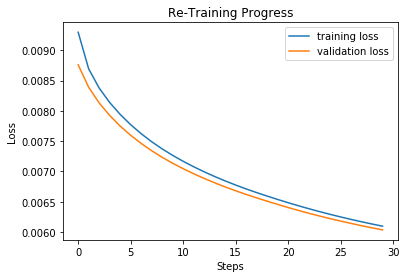

In [20]:
tbHistoryPlot('logs/utrain2')